# **KAIST EE**
#  **[EE488] note 04A. Slime Volleyball (using a reinforcement learning library)**
## **Instructor**: Prof. Yoon, Young-Gyu (ygyoon@kaist.ac.kr)
### This example code was prepared by EE488 teaching assistants Han, Seungjae (jay0118@kaist.ac.kr) & Shin, Changyeop (scey26@kaist.ac.kr).

- Class Date : 22.03.xx.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

### 0. In this example, we will train an agent that plays **Slime Volleyball**  using  Stable Baselines3. The agent will learn the strategy by playing the game **against the AI embedded in the library**.


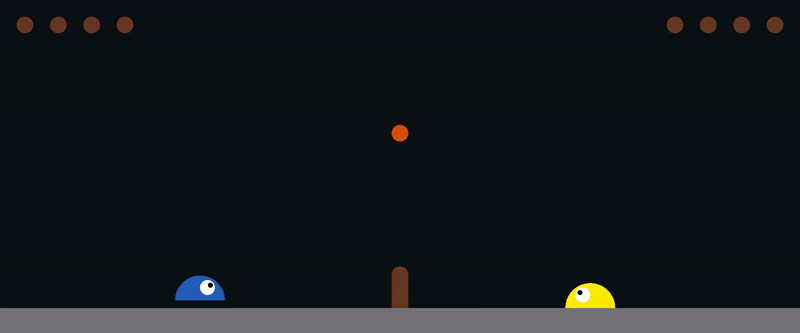





**SlimeVolleyGym** is a simple gym environment for testing single and multi-agent reinforcement learning algorithms.

The game is very simple: the agent's goal is to get the ball to land on the ground of its opponent's side, causing its opponent to lose a life. Each agent starts off with five lives. The episode ends when either agent loses all five lives, or after 3000 timesteps has passed. An agent receives a reward of +1 when its opponent loses or -1 when it loses a life.

You can even try playing the game by yourself here.
https://www.cwest.net/games/slime-volleyball/

More detailed explanation about the game can be found here.
https://github.com/hardmaru/slimevolleygym

**Stable Baselines3**

Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines.

Github repository: https://github.com/DLR-RM/stable-baselines3

Paper: https://jmlr.org/papers/volume22/20-1364/20-1364.pdf
https://stable-baselines3.readthedocs.io/en/master/

Manual: https://stable-baselines3.readthedocs.io/_/downloads/en/master/pdf/

### 1. Let's Install **stable-baselines3** and **SlimeVolleyGym**.

In [2]:
!pip install stable-baselines3[extra]
!pip install slimevolleygym

     |████████████████████████████████| 177 kB 3.2 MB/s 
     |████████████████████████████████| 1.5 MB 34.4 MB/s 
     |████████████████████████████████| 1.6 MB 39.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=5633f0d18bf69604aeb7e06ece58f38b232f6b60274bea3f539618ab0cba5175
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=fcacc1d0c9a0a12b90d89ad932e92c9f717776d6f16a8f18a57e22a4e654132d
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3

### 2. Let's **mount Google drive** so that we can save files as we need.

In [3]:
from google.colab import drive
drive.mount("/content/drive")
import sys
import os

filepath = "/content/drive/My Drive/RL/Tournament/trained_agent/custom/js_custom_4_3/"  # Change this path for your Google drive setting.
sys.path.append(filepath)
experiment = "Volleyball_04"

if not os.path.exists(f"{filepath}"):
    os.makedirs(f"{filepath}")
if not os.path.exists(f"{filepath}/{experiment}"):
    os.makedirs(f"{filepath}/{experiment}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




### 3. Let's install a few more things to setup RL enviroment. 

In [4]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

# Followings are for visualization (as we are running on server without a physical display!)
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

# Autoreload in case that the custom modules are changed
%load_ext autoreload
%autoreload 2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,245 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Re

### 4.  And then, let's **import the libraries** (including SlimeVolleyGym and stable-baselines3) we need to use.

In [5]:
import slimevolleygym
from slimevolleygym import FrameStack
import gym
import time

import base64

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, NoopResetEnv, MaxAndSkipEnv, WarpFrame
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.cmd_util import make_vec_env

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/cmd_util.py:6: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  "Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.", FutureWarning


### 5. We need a bunch of stuff for **visualization** (as we are running on server without a physical display!). Let's not worry about the details here.

In [6]:
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import Monitor as eval_Monitor
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### 6. Here's our function for visualization of the result as a **video**.

In [7]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    os.system('rm -f video/compressed.mp4')
    time.sleep(1)
    mp4 = mp4list[0]
    os.system(f"ffmpeg -i {mp4} -vcodec libx264 video/compressed.mp4")
    video = io.open('video/compressed.mp4', 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
    env = eval_Monitor(env, './video', force=True)
    return env

### 7. Here's a function to **check the training process** and save the intermediate models.

In [8]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

### 8. Let's start **training using PPO algorithm**. You can easily change the hyperparameters if you want. See the manual below. 

https://stable-baselines3.readthedocs.io/_/downloads/en/master/pdf/

Below shows the list of hyperparameters we can change.

**PPO**(policy, env, learning_rate=0.0003, n_steps=2048, batch_size=64,
n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
clip_range_vf=None, normalize_advantage=True, ent_coef=0.0,
vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=- 1,
target_kl=None, tensorboard_log=None, create_eval_env=False,
policy_kwargs=None, verbose=0, seed=None, device='auto',
_init_setup_model=True)


Logging to /content/drive/My Drive/RL/Tournament/trained_agent/custom/js_custom_4/ppo_slimevolleyball_tensorboard/PPO_3
Early stopping at step 0 due to reaching max kl: 0.02
Early stopping at step 0 due to reaching max kl: 0.02
Num timesteps: 1280000
Best mean reward: -inf - Last mean reward per episode: 0.73
Saving new best model to /content/drive/My Drive/RL/Tournament/trained_agent/custom/js_custom_4_3//Volleyball_04/best_model
Early stopping at step 0 due to reaching max kl: 0.03
Early stopping at step 0 due to reaching max kl: 0.02
Num timesteps: 2560000
Best mean reward: 0.73 - Last mean reward per episode: 0.49
Early stopping at step 0 due to reaching max kl: 0.02
Early stopping at step 0 due to reaching max kl: 0.02
Early stopping at step 0 due to reaching max kl: 0.02
Num timesteps: 3840000
Best mean reward: 0.73 - Last mean reward per episode: 0.67
Early stopping at step 0 due to reaching max kl: 0.03
Early stopping at step 0 due to reaching max kl: 0.02
Num timesteps: 512000

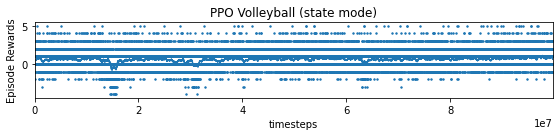

In [9]:
#self-play START
BEST_THRESHOLD = 0.5 # must achieve a mean score above this to replace prev best self
NUM_TIMESTEPS = int(1e8)
EVAL_FREQ = int(1e5)
EVAL_EPISODES = int(1e2)

import torch as th


class RandomPolicy:
  def __init__(self):
    self.action_space = gym.spaces.MultiBinary(3)
    pass
  def predict(self, obs):
    action = self.action_space.sample()
    return action


def linear_schedule(initial_value):
    """
    Linear learning rate schedule.
    :param initial_value: (float or str)
    :return: (function)
    """
    if isinstance(initial_value, str):
        initial_value = float(initial_value)

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0
        :param progress_remaining: (float)
        :return: (float)
        """
        return progress_remaining * initial_value

    return func


# Create log dir
log_dir = f"{filepath}/{experiment}"
# os.makedirs(log_dir, exist_ok=True)

def make_env():
    env = make_vec_env("SlimeVolley-v0",n_envs=128,seed=0,monitor_dir=log_dir) # CHANGE SEED HERE EVERY TIME
    #env.seed(seed)
    return env

env = make_env()


class CustomPolicy:
  def __init__(self):
    self.policy = self
    self.best_model = A2C.load("/content/drive/My Drive/RL/Tournament/trained_agent/A2C/nowrap_js_trial_1/Volleyball_04/best_model.zip")
  def predict(self, obs): # the policy
    action,_ = self.best_model.predict(obs)
    return action

#env.policy =RandomPolicy()
# poorly ppo: "/content/drive/My Drive/AIcapstone/RL/Tournament/trained_agent/PPO/js_trial_6/Volleyball_04/best_model.zip"
# poorly a2c: "/content/drive/My Drive/AIcapstone/RL/Tournament/trained_agent/A2C/nowrap_js_trial_1/Volleyball_04/best_model.zip"
# random: env.policy=RandomPolicy()
# default: #env.policy =CustomPolicy()
# hardmaru1: "/content/drive/MyDrive/AIcapstone/RL/Tournament/trained_agent/hardmaru/ga_sp/ga.json"
# hardmaru2: "/content/drive/MyDrive/AIcapstone/RL/Tournament/trained_agent/hardmaru/cmaes/slimevolley.cma.64.96.best.json"
# hardmaru3: "/content/drive/MyDrive/AIcapstone/RL/Tournament/trained_agent/hardmaru/cmaes_sp/slimevolley.cma.16.384.best.json"

policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=[dict(pi=[256, 256], vf=[256, 256])])

# # Create and wrap the environment
# env = Monitor(make_env(seed=0), log_dir)

#model = A2C("MlpPolicy", env, verbose=1, tensorboard_log="/content/drive/My Drive/AIcapstone/RL/Tournament/trained_agent/trial_3/a2c_slimevolleyball_tensorboard/")
#model = PPO("MlpPolicy", env, n_steps=4096, learning_rate = linear_schedule(0.00025), n_epochs=20, target_kl=0.01, verbose=2, policy_kwargs=policy_kwargs, tensorboard_log="/content/drive/My Drive/RL/Tournament/trained_agent/custom/js_custom_4/ppo_slimevolleyball_tensorboard/")

model = PPO.load("/content/drive/My Drive/RL/Tournament/trained_agent/custom/js_custom_4_2/Volleyball_04/best_model.zip")
model.env = env

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

model.learn(total_timesteps=NUM_TIMESTEPS, callback = callback, eval_freq=10000, log_interval=10000)

plot_results([log_dir], NUM_TIMESTEPS, results_plotter.X_TIMESTEPS, "PPO Volleyball (state mode)")
plt.show()

In [ ]:
%load_ext tensorboard
%cd /content/drive/MyDrive/
ts_log_dir = "trained_agent/PPO/ys_trial_cont/ppo_slimevolleyball_tensorboard/"
%tensorboard --logdir {ts_log_dir}

### 9. Now, let's **evaluate** the performance of the trained network!

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

env = gym.make("SlimeVolley-v0")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(mean_reward, std_reward)


### **Congratulations**! You sucessfully trained your agent that play Slime Volleyball in **state mode**.

---